# Import lib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import random
import os
import joblib

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [3]:
# Set seeds for CPU-based operations
MY_SEED = 101010

# 1. Set the seed across all libraries
tf.random.set_seed(MY_SEED)
np.random.seed(MY_SEED)
random.seed(MY_SEED)


In [4]:
# # Set seeds for CPU-based operations
# MY_SEED = 101010

# # 1. Set the seed across all libraries
# tf.random.set_seed(MY_SEED)
# np.random.seed(MY_SEED)
# random.seed(MY_SEED)

# # Set deterministic flags for GPU operations
# # This is crucial for consistent results across GPU runs!
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Loading data

In [5]:
FILE_PATH = '/content/drive/MyDrive/Oil-anomoly-detection/Volve_production_data.xlsx'
TARGET_WELL = 'NO 15/9-F-14 H' # A high-production well to focus on

In [6]:
df_primary = pd.read_excel(FILE_PATH, sheet_name=0, header=0)

In [7]:
df_primary.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


In [8]:
df_primary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15634 entries, 0 to 15633
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATEPRD                   15634 non-null  datetime64[ns]
 1   WELL_BORE_CODE            15634 non-null  object        
 2   NPD_WELL_BORE_CODE        15634 non-null  int64         
 3   NPD_WELL_BORE_NAME        15634 non-null  object        
 4   NPD_FIELD_CODE            15634 non-null  int64         
 5   NPD_FIELD_NAME            15634 non-null  object        
 6   NPD_FACILITY_CODE         15634 non-null  int64         
 7   NPD_FACILITY_NAME         15634 non-null  object        
 8   ON_STREAM_HRS             15349 non-null  float64       
 9   AVG_DOWNHOLE_PRESSURE     8980 non-null   float64       
 10  AVG_DOWNHOLE_TEMPERATURE  8980 non-null   float64       
 11  AVG_DP_TUBING             8980 non-null   float64       
 12  AVG_ANNULUS_PRESS 

In [9]:
df_primary['WELL_BORE_CODE'].unique()

array(['NO 15/9-F-1 C', 'NO 15/9-F-11 H', 'NO 15/9-F-12 H',
       'NO 15/9-F-14 H', 'NO 15/9-F-15 D', 'NO 15/9-F-4 AH',
       'NO 15/9-F-5 AH'], dtype=object)

In [10]:
df = df_primary[df_primary["WELL_BORE_CODE"] == TARGET_WELL].copy()

# Preprocessing

In [11]:
df.sort_values(by='DATEPRD', ascending=True, inplace=True)

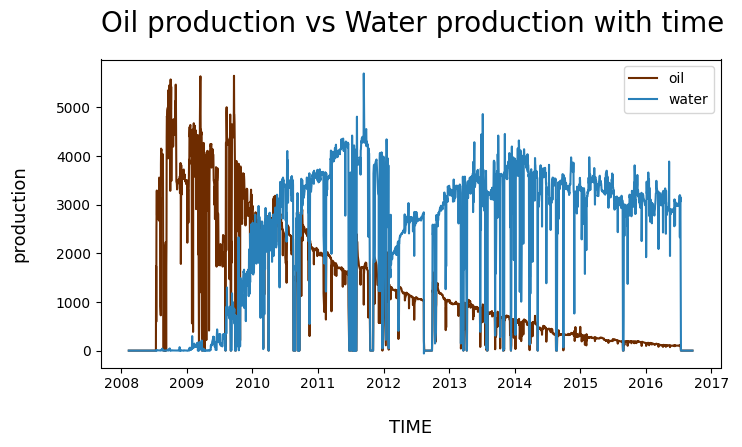

In [12]:
# main figure object
plt.figure(figsize= (8,4))
# make scatter plot between oil and gas production
plt.plot( df["DATEPRD"], df["BORE_OIL_VOL"],color="#6E2C00",label="oil")
plt.plot(df["DATEPRD"],df["BORE_WAT_VOL"],color="#2980B9",label="water");

# setting axes (x and y) labels
plt.xlabel("TIME", fontsize= 13, labelpad = 20)
plt.ylabel("production", fontsize= 13, labelpad = 20,loc="center")

# setting figure title
plt.title("Oil production vs Water production with time ", fontsize= 20, pad = 20,loc="left")

plt.legend();

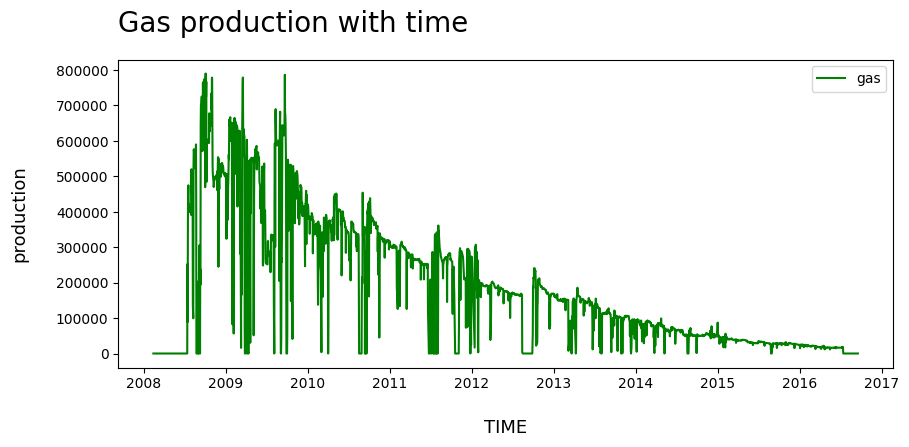

In [13]:
# main figure object
plt.figure(figsize= (10,4))
plt.plot( df["DATEPRD"], df["BORE_GAS_VOL"],color="#008000",label="gas")
# setting axes (x and y) labels
plt.xlabel("TIME", fontsize= 13, labelpad = 20)
plt.ylabel("production", fontsize= 13, labelpad = 20,loc="center")

# setting figure title
plt.title("Gas production with time ", fontsize= 20, pad = 20,loc="left")
plt.legend();

<Axes: >

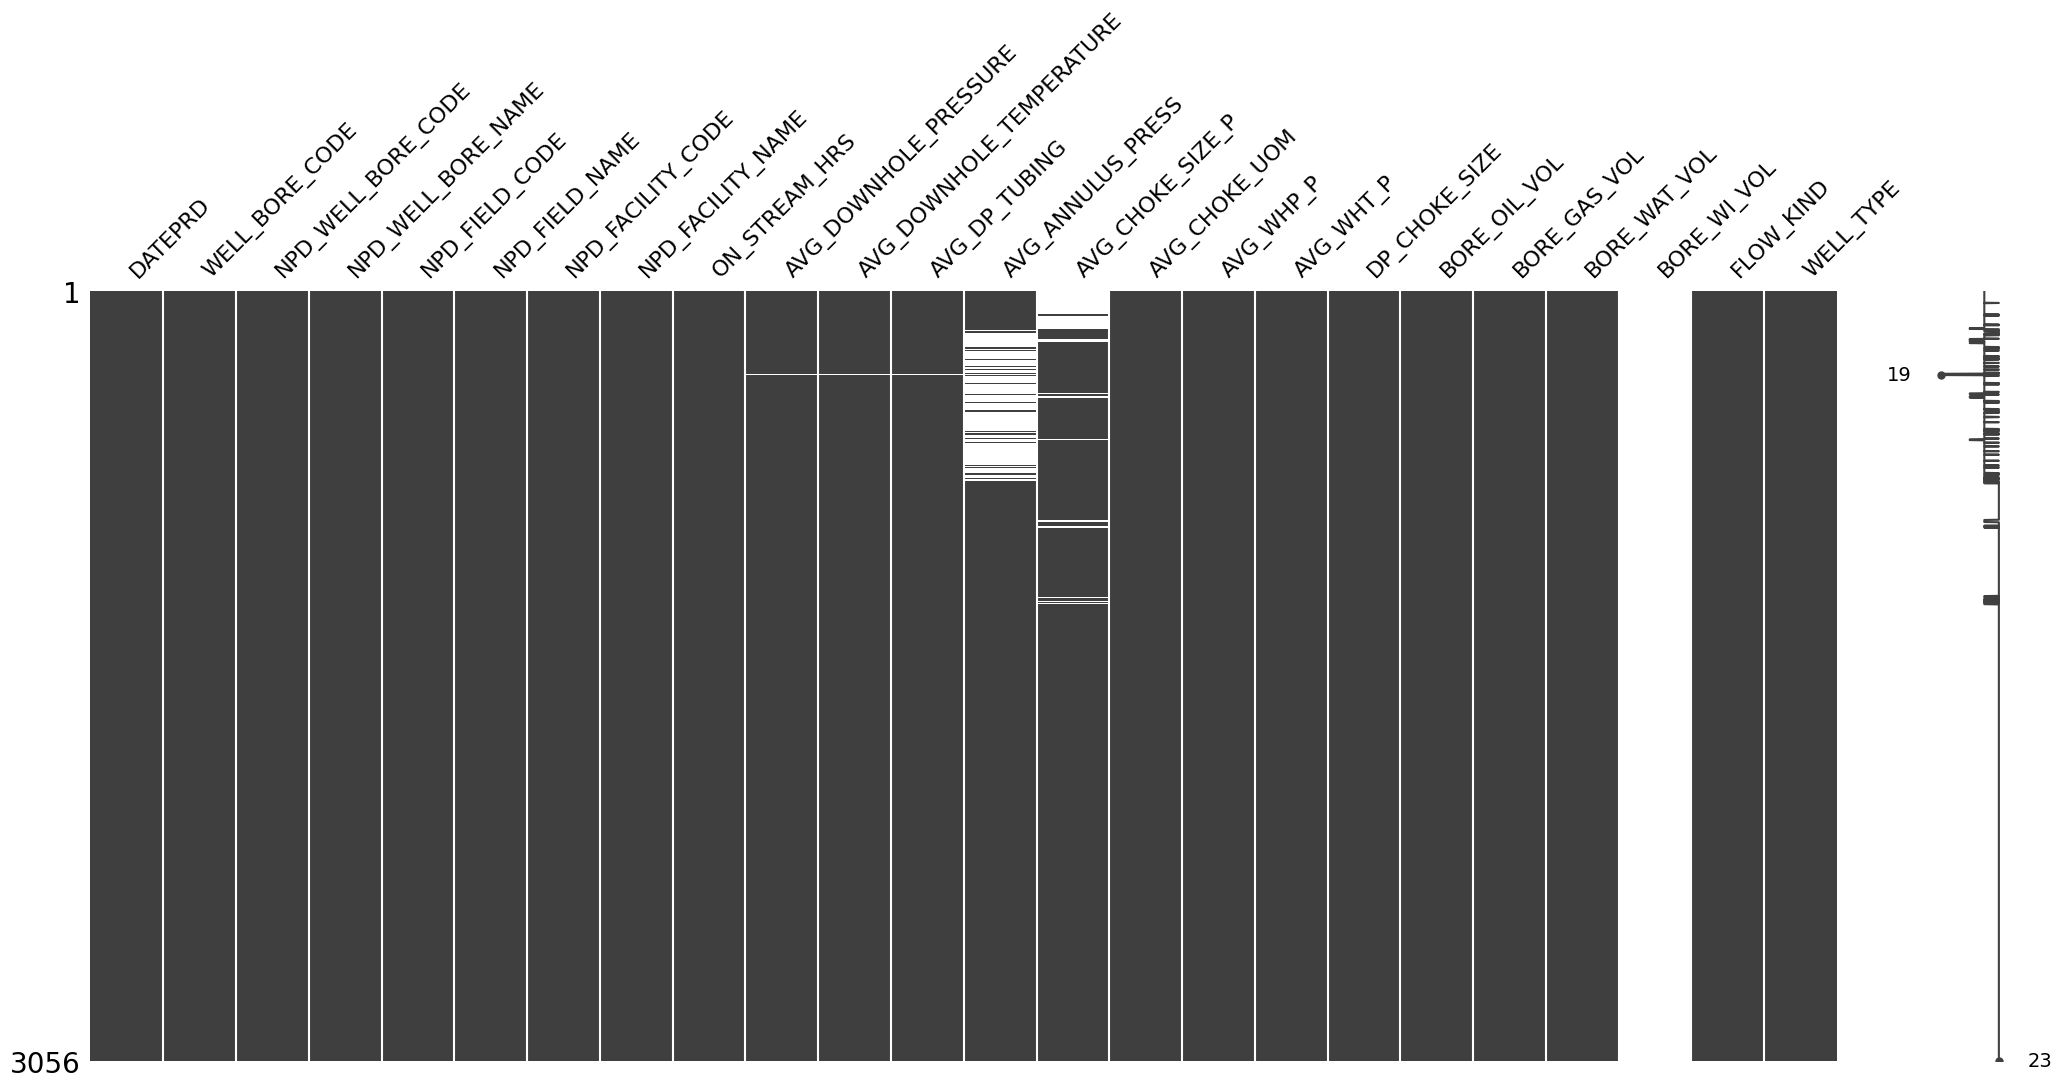

In [14]:
ms.matrix(df)

In [15]:
df.isnull().sum()

,0
DATEPRD,0
WELL_BORE_CODE,0
NPD_WELL_BORE_CODE,0
NPD_WELL_BORE_NAME,0
NPD_FIELD_CODE,0
NPD_FIELD_NAME,0
NPD_FACILITY_CODE,0
NPD_FACILITY_NAME,0
ON_STREAM_HRS,0
AVG_DOWNHOLE_PRESSURE,6


In [16]:
# --- 1. Drop rows with missing critical sensor data ---
# We define a small subset of columns to check for NaNs.
CRITICAL_SENSORS = [
    'AVG_DOWNHOLE_PRESSURE',
    'AVG_DOWNHOLE_TEMPERATURE',
    'AVG_DP_TUBING'
]

initial_rows = df.shape[0]
df.dropna(subset=CRITICAL_SENSORS, inplace=True)
rows_dropped = initial_rows - df.shape[0]

print(f"Dropped {rows_dropped} rows missing data from critical sensor columns.")
print(f"Remaining records: {df.shape[0]}")

# --- 2. Remove columns not needed for modeling ---
# We defined these earlier; they are identifiers or irrelevant for a producer well.
COLUMNS_TO_DROP_FINALLY = [
    'NPD_WELL_BORE_CODE',
    'NPD_WELL_BORE_NAME',
    'NPD_FIELD_CODE',
    'NPD_FIELD_NAME',
    'NPD_FACILITY_CODE',
    'NPD_FACILITY_NAME',
    'AVG_CHOKE_UOM',
    'BORE_WI_VOL',
    'WELL_BORE_CODE',
    'FLOW_KIND',
    'WELL_TYPE'
]

# Only drop columns if they still exist in the DataFrame
cols_to_drop = [col for col in COLUMNS_TO_DROP_FINALLY if col in df.columns]
df.drop(columns=cols_to_drop, inplace=True)

print("Remaining columns after dropping unnecessary metadata:")
print(df.columns.tolist())

Dropped 6 rows missing data from critical sensor columns.
Remaining records: 3050
Remaining columns after dropping unnecessary metadata:
['DATEPRD', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']


In [17]:
df.describe()

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
count,3050,3050.000000,3050.000000,3050.000000,3050.000000,2533.000000,2854.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000
mean,2012-06-07 01:11:17.508196864,20.534320,233.074650,95.133792,192.653083,10.527984,69.469919,41.425426,77.108397,15.343223,1286.229662,188599.197072,2334.834092
min,2008-02-12 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-59.190000
25%,2010-03-29 06:00:00,24.000000,237.493045,99.620673,180.749433,0.000000,43.035278,31.019271,81.315549,2.650836,209.570000,31189.217500,722.855000
50%,2012-06-13 12:00:00,24.000000,246.776063,101.007540,204.247625,12.968633,71.112325,33.507665,86.965995,7.109115,878.360000,141330.405000,2970.595000
75%,2014-08-16 18:00:00,24.000000,261.970976,105.049314,229.632848,21.231843,100.000000,48.769246,88.542293,20.929513,2026.295000,303559.890000,3445.085000
max,2016-09-17 00:00:00,25.000000,334.656140,106.772733,302.109760,26.682243,100.000000,125.718570,93.509584,125.718570,5644.370000,789974.730000,5691.770000
std,NaN,7.887469,64.923764,25.846815,57.736985,9.704604,31.048445,22.617483,25.640539,19.875089,1296.777624,183970.808947,1460.716050


In [18]:
# Assuming 'df' is the DataFrame after the initial date/type cleaning (before final interpolation)

print("--- Calculating Normalized Production Rates (Volume per Hour) ---")

# Define the columns for rate calculation
VOLUME_COLUMNS = ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']
RATE_COLUMNS = ['OIL_RATE_BBL_HR', 'GAS_RATE_MSCF_HR', 'WAT_RATE_BBL_HR']
RATE_MAP = dict(zip(VOLUME_COLUMNS, RATE_COLUMNS))

for vol_col, rate_col in RATE_MAP.items():

    # 1. Calculate the rate (will result in NaN/Inf where ON_STREAM_HRS is 0)
    df[rate_col] = df[vol_col] / df['ON_STREAM_HRS']

    # 2. CRITICAL FIX: Explicitly set the rate to 0.0 for full shutdown days
    is_shutdown = (df['ON_STREAM_HRS'] == 0)
    df.loc[is_shutdown, rate_col] = 0.0

    # 3. FIX WARNING: Use direct assignment to replace Inf/-Inf with 0.0
    # We assign the result of the replacement back to the column explicitly.
    df[rate_col] = df[rate_col].replace([np.inf, -np.inf], 0.0)

    # 4. FIX WARNING: Use direct assignment to fill NaNs with 0.0
    df[rate_col] = df[rate_col].fillna(0.0)

    print(f"Created rate column: {rate_col}")

--- Calculating Normalized Production Rates (Volume per Hour) ---
Created rate column: OIL_RATE_BBL_HR
Created rate column: GAS_RATE_MSCF_HR
Created rate column: WAT_RATE_BBL_HR


<Axes: title={'center': 'Linear correlation coefs between all the features'}>

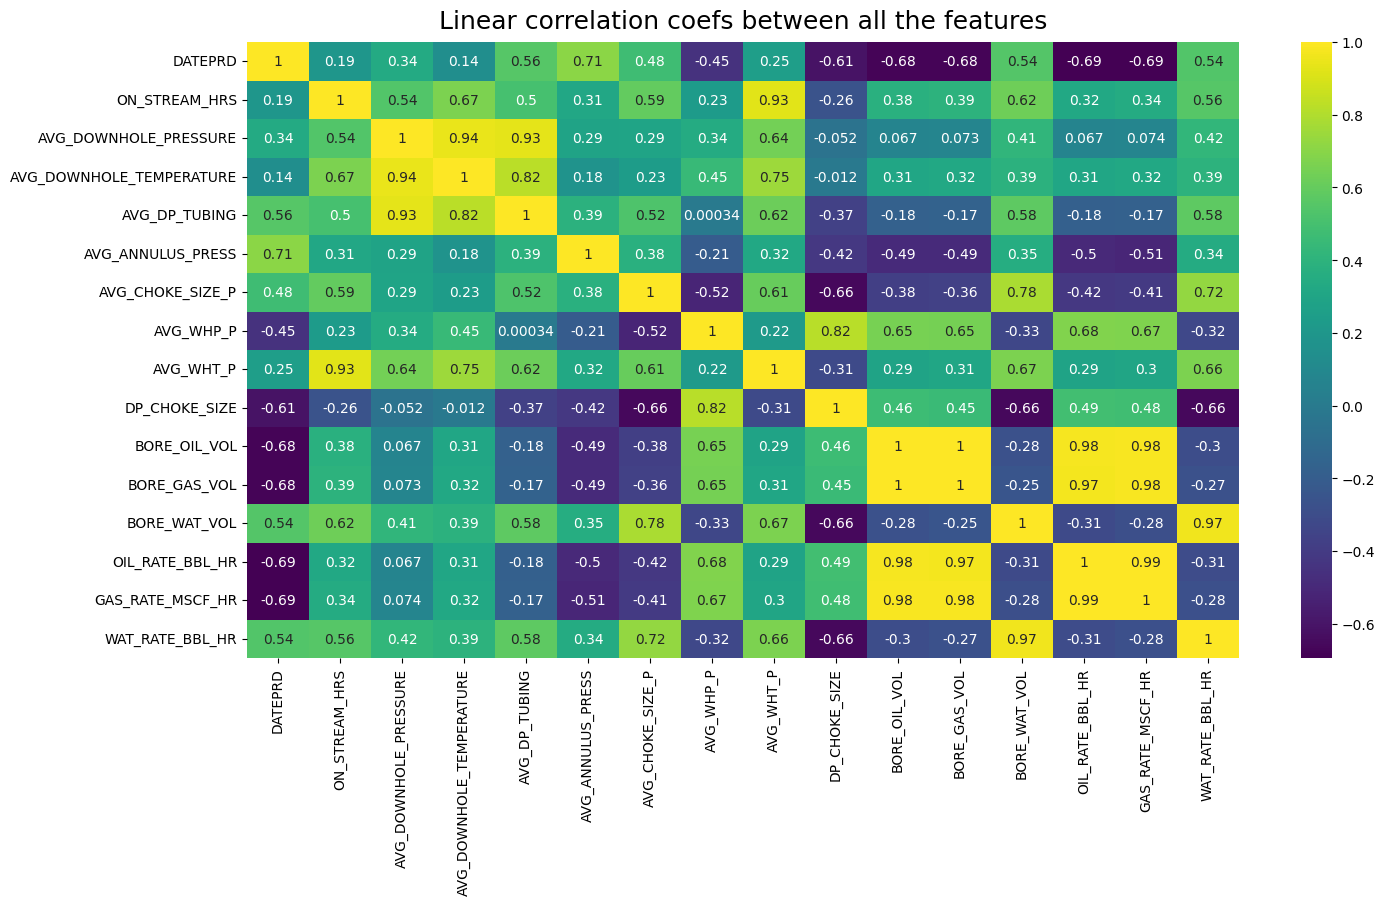

In [19]:
plt.figure(figsize=(16,8))
plt.title("Linear correlation coefs between all the features",fontsize=18,pad=10)
sns.heatmap(df.corr(), annot=True, cmap="viridis")

In [20]:
# Filtering: Remove Full Shutdown Days (where ON_STREAM_HRS was originally 0)
# Filtering AFTER calculation prevents massive gaps that would ruin interpolation.

# Now, we filter out the full shutdown days (where ON_STREAM_HRS was 0)
df = df[df["ON_STREAM_HRS"] > 1e-6].copy() # Using a tiny threshold handles float precision

print(f"\n--- Full Shutdown Filtering ---")
print(f"Active Production Records remaining: {df.shape[0]}")

# Drop the raw volume columns and the ON_STREAM_HRS column
cols_to_drop = VOLUME_COLUMNS + ['ON_STREAM_HRS']
df.drop(columns=cols_to_drop, inplace=True)

# Define the final features list for the model input
FINAL_FEATURES = [
    'DATEPRD',
    'AVG_DOWNHOLE_PRESSURE',
    'AVG_ANNULUS_PRESS',
    'DP_CHOKE_SIZE',
    'OIL_RATE_BBL_HR',
    'GAS_RATE_MSCF_HR',
    'WAT_RATE_BBL_HR'
]

# Create the final DataFrame for the next steps
daily_df_final = df[FINAL_FEATURES].copy()
print("\nFinal DataFrame ready for scaling with all 6 features:")
print(daily_df_final.head())


--- Full Shutdown Filtering ---
Active Production Records remaining: 2718

Final DataFrame ready for scaling with all 6 features:
        DATEPRD  AVG_DOWNHOLE_PRESSURE  AVG_ANNULUS_PRESS  DP_CHOKE_SIZE  \
5118 2008-07-13             260.866875                0.0      69.539413   
5119 2008-07-14             256.248230                0.0      68.016167   
5120 2008-07-15             254.982785                0.0      66.948884   
5121 2008-07-16             251.475921                0.0      63.663812   
5122 2008-07-17             249.346191                0.0      61.337700   

      OIL_RATE_BBL_HR  GAS_RATE_MSCF_HR  WAT_RATE_BBL_HR  
5118        72.302500      10509.801250         0.166667  
5119       106.348294      15969.299820         0.245961  
5120       105.508750      15574.428333         0.243333  
5121       126.279583      18660.003750         0.380417  
5122       137.003333      19775.601250         0.315833  


In [21]:
df.isnull().sum()

,0
DATEPRD,0
AVG_DOWNHOLE_PRESSURE,0
AVG_DOWNHOLE_TEMPERATURE,0
AVG_DP_TUBING,0
AVG_ANNULUS_PRESS,493
AVG_CHOKE_SIZE_P,0
AVG_WHP_P,0
AVG_WHT_P,0
DP_CHOKE_SIZE,0
OIL_RATE_BBL_HR,0


In [22]:
daily_df_final.loc[daily_df_final['WAT_RATE_BBL_HR'] < 0, 'WAT_RATE_BBL_HR'] = 0.0

In [23]:
print("--- Imputing Remaining Missing Values ---")

# Apply linear interpolation to fill gaps in the time series
# This is ideal for sensor and control readings (like pressure and choke size).
daily_df_final.interpolate(method='linear', inplace=True)

# Fill any remaining NaNs at the very start or very end of the series
# Use the next available value (bfill) then the last available value (ffill)
daily_df_final.fillna(method='bfill', inplace=True)
daily_df_final.fillna(method='ffill', inplace=True)

print("Remaining Missing Values per Feature after Imputation:")
print(daily_df_final.isnull().sum())

--- Imputing Remaining Missing Values ---
Remaining Missing Values per Feature after Imputation:
DATEPRD                  0
AVG_DOWNHOLE_PRESSURE    0
AVG_ANNULUS_PRESS        0
DP_CHOKE_SIZE            0
OIL_RATE_BBL_HR          0
GAS_RATE_MSCF_HR         0
WAT_RATE_BBL_HR          0
dtype: int64


/tmp/ipython-input-852067485.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_df_final.fillna(method='bfill', inplace=True)
/tmp/ipython-input-852067485.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_df_final.fillna(method='ffill', inplace=True)


In [24]:
daily_df_final.set_index('DATEPRD', inplace=True)

In [25]:
# --- Configuration for Split and Sequencing ---
TRAINING_START_DATE = '2008-07-13'
TRAINING_END_DATE = '2014-06-30'
TIME_STEPS = 60 # The look-back window (60 days)

# Split the data into Training and Test Sets
X_train = daily_df_final.loc[TRAINING_START_DATE:TRAINING_END_DATE].values
X_test = daily_df_final.loc[TRAINING_END_DATE:].values

print(f"X_train size (Normal Data): {X_train.shape[0]} records")
print(f"X_test size (Anomaly Test Data): {X_test.shape[0]} records")

# Initialize the scaler
scaler = MinMaxScaler()

# FIT THE SCALER *ONLY* ON THE TRAINING DATA!
scaler.fit(X_train)

# Transform both training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to convert 2D data into 3D sequences [Samples, Time Steps, Features]
def create_sequences(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps + 1):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)

# Create the final 3D tensor for the LSTM
X_train_seq = create_sequences(X_train_scaled, TIME_STEPS)
X_test_seq = create_sequences(X_test_scaled, TIME_STEPS)

print(f"\nFinal Training Data Shape: {X_train_seq.shape} (Samples, Time Steps, Features)")
print(f"Final Test Data Shape: {X_test_seq.shape} (Samples, Time Steps, Features)")

X_train size (Normal Data): 1983 records
X_test size (Anomaly Test Data): 736 records

Final Training Data Shape: (1924, 60, 6) (Samples, Time Steps, Features)
Final Test Data Shape: (677, 60, 6) (Samples, Time Steps, Features)


# Training and evaluate model

## 60 days

In [26]:
# --- Configuration for Split and Sequencing ---
TRAINING_START_DATE = '2008-07-13'
TRAINING_END_DATE = '2014-06-30'
TIME_STEPS = 60 # The look-back window (60 days)

# Split the data into Training and Test Sets
X_train = daily_df_final.loc[TRAINING_START_DATE:TRAINING_END_DATE].values
X_test = daily_df_final.loc[TRAINING_END_DATE:].values

print(f"X_train size (Normal Data): {X_train.shape[0]} records")
print(f"X_test size (Anomaly Test Data): {X_test.shape[0]} records")

# Initialize the scaler
scaler = MinMaxScaler()

# FIT THE SCALER *ONLY* ON THE TRAINING DATA!
scaler.fit(X_train)

# Transform both training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to convert 2D data into 3D sequences [Samples, Time Steps, Features]
def create_sequences(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps + 1):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)

# Create the final 3D tensor for the LSTM
X_train_seq = create_sequences(X_train_scaled, TIME_STEPS)
X_test_seq = create_sequences(X_test_scaled, TIME_STEPS)

print(f"\nFinal Training Data Shape: {X_train_seq.shape} (Samples, Time Steps, Features)")
print(f"Final Test Data Shape: {X_test_seq.shape} (Samples, Time Steps, Features)")

# X_train_seq.shape[2] holds the number of features (6 in our case)
N_FEATURES = X_train_seq.shape[2]

X_train size (Normal Data): 1983 records
X_test size (Anomaly Test Data): 736 records

Final Training Data Shape: (1924, 60, 6) (Samples, Time Steps, Features)
Final Test Data Shape: (677, 60, 6) (Samples, Time Steps, Features)


In [27]:
# --- 1. Define the Model Architecture ---

model = Sequential([
    # ENCODER
    LSTM(128, activation='tanh', input_shape=(TIME_STEPS, N_FEATURES), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),

    # BOTTLENECK
    RepeatVector(TIME_STEPS), # Repeats the 64-unit vector TIME_STEPS (30) times

    # DECODER
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),

    # OUTPUT
    # TimeDistributed applies the Dense layer independently to each of the 30 time steps
    TimeDistributed(Dense(N_FEATURES))
])

# --- 2. Compile the Model ---
# We use Mean Absolute Error (MAE) as the loss function, which is the reconstruction error.
model.compile(optimizer='adam', loss='mae')

# --- 3. Display Summary ---
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 6)          │           774 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,142 (981.02 KB)

 Trainable params: 251,142 (981.02 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
print("--- Training the LSTM Autoencoder ---")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, mode='min'),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
]

history = model.fit(
    X_train_seq, X_train_seq,  # Input and Target are the same (Autoencoder)
    epochs=100,                # High number of epochs, EarlyStopping will manage it
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

# Load the best saved model after training is finished
best_model = load_model('best_model.keras')

--- Training the LSTM Autoencoder ---
Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - loss: 0.1669 - val_loss: 0.0505
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - loss: 0.0622 - val_loss: 0.0474
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - loss: 0.0545 - val_loss: 0.0360
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - loss: 0.0480 - val_loss: 0.0389
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step - loss: 0.0439 - val_loss: 0.0326
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - loss: 0.0415 - val_loss: 0.0382
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - loss: 0.0394 - val_loss: 0.0314
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step - loss: 0.0370 - val_loss: 0.0358
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step - loss: 0.0364 - val_loss: 0.0272
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - loss: 0.0352 - val_loss: 0.0282
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step - loss: 0.0349 - val_loss:

In [29]:
# Load the best model saved during training
best_model = load_model('best_model.keras')

print("Calculating Reconstruction Error ---")

# 1. Predict (Reconstruct) the Test Data Sequences
# X_test_seq contains the 3D sequences of data after the training period
X_test_pred = best_model.predict(X_test_seq, verbose=0)

# 2. Calculate the Mean Absolute Error (MAE)
# The MAE is calculated between the original sequence (X_test_seq) and the reconstructed sequence (X_test_pred).
test_mae_loss = np.mean(np.abs(X_test_pred - X_test_seq), axis=1)

# The resulting test_mae_loss is a 2D array: [Samples, Features]
# We take the mean across the features to get a single loss value per time step
test_mae_loss = np.mean(test_mae_loss, axis=1)

# Create a DataFrame for the test loss, using the adjusted index
X_test_index = daily_df_final.loc[TRAINING_END_DATE:].index
X_test_index_seq = X_test_index[TIME_STEPS - 1:]

test_loss_df = pd.DataFrame(
    test_mae_loss,
    index=X_test_index_seq, # The adjusted index saved in the previous step
    columns=['Loss']
)

print(f"Test Loss Calculated. Total data points: {test_loss_df.shape[0]}")

# --- 3. Determine the Anomaly Threshold ---

# Now we must define what level of error is considered "abnormal."
# We calculate the loss for the *training* data (which is all normal).
X_train_pred = best_model.predict(X_train_seq, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train_seq), axis=1)
train_mae_loss = np.mean(train_mae_loss, axis=1)

# Set the threshold at the 95th or 99th percentile of the training loss.
# We will use the 95th percentile for a good balance of sensitivity.
ANOMALY_THRESHOLD = np.quantile(train_mae_loss, 0.95)

print(f"\nTraining Loss (Normal Data) 95th Percentile Threshold: {ANOMALY_THRESHOLD:.6f}")

# 4. Flag Anomalies in the Test Data
test_loss_df['Anomaly'] = test_loss_df['Loss'] > ANOMALY_THRESHOLD
test_loss_df['Original_Index'] = test_loss_df.index # Save the date as a column for easier plotting

# Get the dates where an anomaly was flagged
anomalies = test_loss_df[test_loss_df['Anomaly'] == True]

print(f"Total Anomalous Days Detected: {anomalies.shape[0]}")
# print("Dates of Detected Anomalies:")
# print(anomalies.index.tolist())

Calculating Reconstruction Error ---
Test Loss Calculated. Total data points: 677

Training Loss (Normal Data) 95th Percentile Threshold: 0.069182
Total Anomalous Days Detected: 80


Plotting results using 95th Percentile Threshold: 0.069182


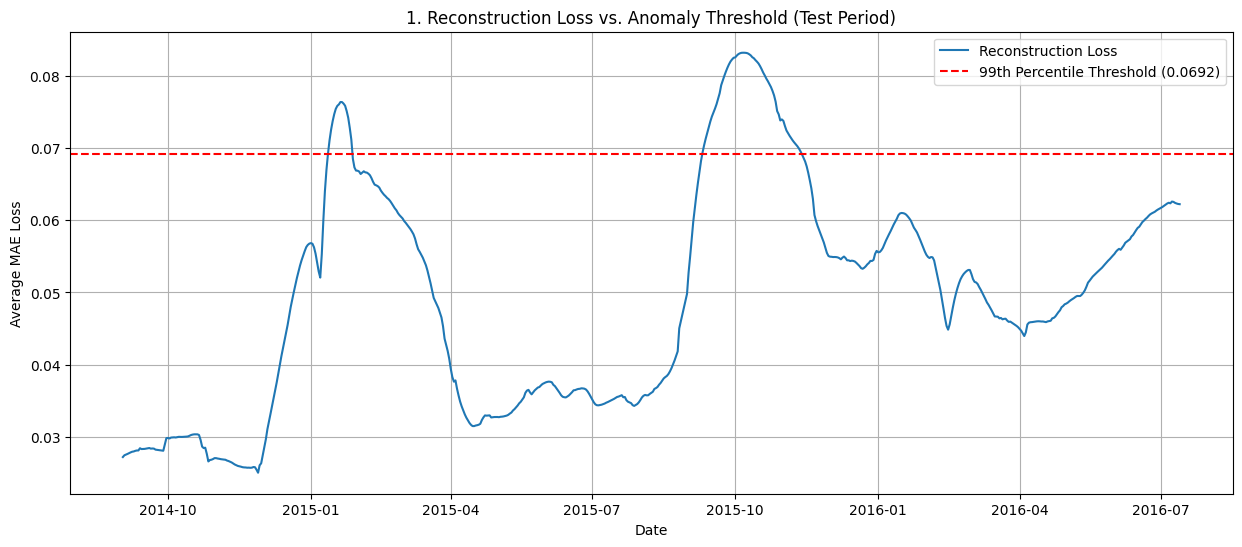

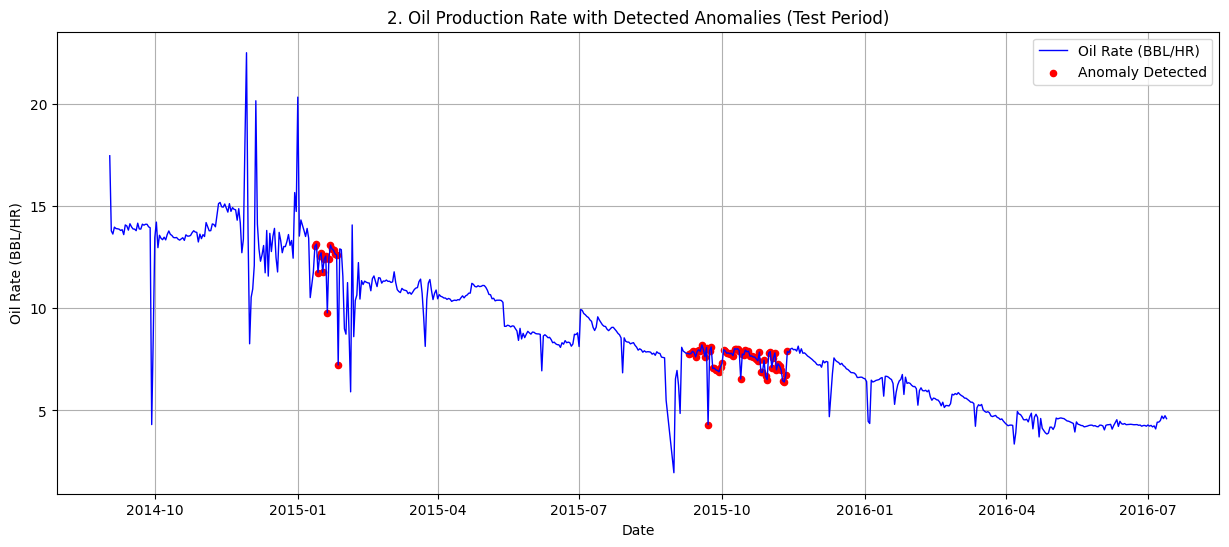

In [30]:
# --- Load and Re-Calculate Final Data (Ensuring consistency with the 99th Pct run) ---
# Assuming best_model, X_test_seq, X_train_seq, X_test_index_seq, and daily_df_final are defined

# Load the best model
best_model = load_model('best_model.keras')

# Calculate Test Loss
X_test_pred = best_model.predict(X_test_seq, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test_seq), axis=1)
test_mae_loss = np.mean(test_mae_loss, axis=1)

# Calculate Training Loss and 99th Pct Threshold
X_train_pred = best_model.predict(X_train_seq, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train_seq), axis=1)
train_mae_loss = np.mean(train_mae_loss, axis=1)
ANOMALY_THRESHOLD = np.quantile(train_mae_loss, 0.95) # Using the confirmed 99th Pct

# Create loss DataFrame and flag anomalies
test_loss_df = pd.DataFrame(
    test_mae_loss,
    index=X_test_index_seq,
    columns=['Loss']
)
test_loss_df['Anomaly'] = test_loss_df['Loss'] > ANOMALY_THRESHOLD

# Prepare data for Plot 2
test_data_with_loss = daily_df_final.loc[X_test_index_seq]
test_data_with_loss['Anomaly'] = test_loss_df['Anomaly']
oil_rate_test = test_data_with_loss['OIL_RATE_BBL_HR']
anomalous_points = test_data_with_loss.loc[test_data_with_loss['Anomaly'] == True]

print(f"Plotting results using 95th Percentile Threshold: {ANOMALY_THRESHOLD:.6f}")


# --- Plot 1: Reconstruction Loss vs. Threshold ---
plt.figure(figsize=(15, 6))
plt.plot(test_loss_df.index, test_loss_df['Loss'], label='Reconstruction Loss')
plt.axhline(ANOMALY_THRESHOLD, color='r', linestyle='--', label=f'99th Percentile Threshold ({ANOMALY_THRESHOLD:.4f})')
plt.title('1. Reconstruction Loss vs. Anomaly Threshold (Test Period)')
plt.xlabel('Date')
plt.ylabel('Average MAE Loss')
plt.legend()
plt.grid(True)
plt.show()



# --- Plot 2: Oil Production Rate vs. Anomalies ---
plt.figure(figsize=(15, 6))
plt.plot(oil_rate_test.index, oil_rate_test.values, label='Oil Rate (BBL/HR)', color='blue', linewidth=1)
plt.scatter(anomalous_points.index, anomalous_points['OIL_RATE_BBL_HR'], color='red', marker='o', s=20, label='Anomaly Detected')
plt.title('2. Oil Production Rate with Detected Anomalies (Test Period)')
plt.xlabel('Date')
plt.ylabel('Oil Rate (BBL/HR)')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Assuming X_test_seq, X_test_pred (prediction from best_model),
# and the boolean mask 'test_loss_df['Anomaly_99']' are defined.

# 1. Get the indices where the anomaly flag was TRUE
anomaly_indices_mask = test_loss_df['Anomaly'].values

# 2. Filter the original sequences (X_test_seq) and predictions (X_test_pred)
# to only include the anomalous sequences.
X_anomaly_original = X_test_seq[anomaly_indices_mask]
X_anomaly_predicted = X_test_pred[anomaly_indices_mask]

# The resulting shapes are [22 samples, 60 time steps, 6 features]
print(f"Isolated Anomaly Data Shape: {X_anomaly_original.shape}")

Isolated Anomaly Data Shape: (80, 60, 6)


In [32]:
# The feature names (in the order they appeared in daily_df_final)
FEATURE_NAMES = daily_df_final.columns.tolist()

# 1. Calculate the Absolute Error
# Shape: [22 samples, 60 time steps, 6 features]
absolute_error = np.abs(X_anomaly_original - X_anomaly_predicted)

# 2. Average the error across the samples (22) and the time steps (60)
# This results in 6 final values (one average MAE per feature)
feature_mae_contribution = np.mean(absolute_error, axis=(0, 1))

# 3. Create a clean results DataFrame
mae_contribution_df = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'Average_MAE': feature_mae_contribution
})

# Sort the results to show the largest contributor first
mae_contribution_df = mae_contribution_df.sort_values(by='Average_MAE', ascending=False).reset_index(drop=True)

print("\n--- Anomaly Feature Contribution Analysis ---")
print(mae_contribution_df)


--- Anomaly Feature Contribution Analysis ---
                 Feature  Average_MAE
0      AVG_ANNULUS_PRESS     0.218287
1  AVG_DOWNHOLE_PRESSURE     0.099835
2       GAS_RATE_MSCF_HR     0.055063
3          DP_CHOKE_SIZE     0.036370
4        OIL_RATE_BBL_HR     0.033655
5        WAT_RATE_BBL_HR     0.018153


## 90 days

In [33]:
# --- Configuration for Split and Sequencing ---
TRAINING_START_DATE = '2008-07-13'
TRAINING_END_DATE = '2014-06-30'
TIME_STEPS = 90 # The look-back window (\90 days)

# Split the data into Training and Test Sets
X_train = daily_df_final.loc[TRAINING_START_DATE:TRAINING_END_DATE].values
X_test = daily_df_final.loc[TRAINING_END_DATE:].values

print(f"X_train size (Normal Data): {X_train.shape[0]} records")
print(f"X_test size (Anomaly Test Data): {X_test.shape[0]} records")

# Initialize the scaler
scaler = MinMaxScaler()

# FIT THE SCALER *ONLY* ON THE TRAINING DATA!
scaler.fit(X_train)

# Transform both training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to convert 2D data into 3D sequences [Samples, Time Steps, Features]
def create_sequences(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps + 1):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)

# Create the final 3D tensor for the LSTM
X_train_seq = create_sequences(X_train_scaled, TIME_STEPS)
X_test_seq = create_sequences(X_test_scaled, TIME_STEPS)

print(f"\nFinal Training Data Shape: {X_train_seq.shape} (Samples, Time Steps, Features)")
print(f"Final Test Data Shape: {X_test_seq.shape} (Samples, Time Steps, Features)")

X_train size (Normal Data): 1983 records
X_test size (Anomaly Test Data): 736 records

Final Training Data Shape: (1894, 90, 6) (Samples, Time Steps, Features)
Final Test Data Shape: (647, 90, 6) (Samples, Time Steps, Features)


In [34]:
# X_train_seq.shape[2] holds the number of features (6 in our case)
N_FEATURES = X_train_seq.shape[2]

# --- 1. Define the Model Architecture ---
model = Sequential([
    # ENCODER
    LSTM(128, activation='tanh', input_shape=(TIME_STEPS, N_FEATURES), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),

    # BOTTLENECK
    RepeatVector(TIME_STEPS), # Repeats the 64-unit vector TIME_STEPS (30) times

    # DECODER
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),

    # OUTPUT
    # TimeDistributed applies the Dense layer independently to each of the 30 time steps
    TimeDistributed(Dense(N_FEATURES))
])

# --- 2. Compile the Model ---
# We use Mean Absolute Error (MAE) as the loss function, which is the reconstruction error.
model.compile(optimizer='adam', loss='mae')

# --- 3. Display Summary ---
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 90, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 90, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 90, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 90, 6)          │           774 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,142 (981.02 KB)

 Trainable params: 251,142 (981.02 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train the model
print("--- Training the LSTM Autoencoder ---")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, mode='min'),
    ModelCheckpoint('best_model_90d.keras', save_best_only=True, monitor='val_loss', mode='min')
]

history = model.fit(
    X_train_seq, X_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

--- Training the LSTM Autoencoder ---
Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 390ms/step - loss: 0.1604 - val_loss: 0.0510
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 402ms/step - loss: 0.0612 - val_loss: 0.0470
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - loss: 0.0548 - val_loss: 0.0343
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - loss: 0.0505 - val_loss: 0.0423
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - loss: 0.0493 - val_loss: 0.0662
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - loss: 0.0455 - val_loss: 0.0389
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - loss: 0.0429 - val_loss: 0.0396
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 391ms/step - loss: 0.0413 - val_loss: 0.0278
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 353ms/step - loss: 0.0405 - val_loss: 0.0261
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - loss: 0.0400 - val_loss: 0.0240
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - loss: 0.0378 - val_loss:

In [36]:
# Load the best model saved during training
best_model_90d = load_model('best_model_90d.keras')

print("Calculating Reconstruction Error ---")

# 1. Predict (Reconstruct) the Test Data Sequences
# X_test_seq contains the 3D sequences of data after the training period
X_test_pred = best_model_90d.predict(X_test_seq, verbose=0)

# 2. Calculate the Mean Absolute Error (MAE)
# The MAE is calculated between the original sequence (X_test_seq) and the reconstructed sequence (X_test_pred).
test_mae_loss = np.mean(np.abs(X_test_pred - X_test_seq), axis=1)

# The resulting test_mae_loss is a 2D array: [Samples, Features]
# We take the mean across the features to get a single loss value per time step
test_mae_loss = np.mean(test_mae_loss, axis=1)

# Create a DataFrame for the test loss, using the adjusted index
X_test_index = daily_df_final.loc[TRAINING_END_DATE:].index
X_test_index_seq = X_test_index[TIME_STEPS - 1:]

test_loss_df = pd.DataFrame(
    test_mae_loss,
    index=X_test_index_seq, # The adjusted index saved in the previous step
    columns=['Loss']
)

print(f"Test Loss Calculated. Total data points: {test_loss_df.shape[0]}")

# --- 3. Determine the Anomaly Threshold ---

# Now we must define what level of error is considered "abnormal."
# We calculate the loss for the *training* data (which is all normal).
X_train_pred = best_model_90d.predict(X_train_seq, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train_seq), axis=1)
train_mae_loss = np.mean(train_mae_loss, axis=1)

# Set the threshold at the 95th or 99th percentile of the training loss.
# We will use the 95th percentile for a good balance of sensitivity.
ANOMALY_THRESHOLD = np.quantile(train_mae_loss, 0.95)

print(f"\nTraining Loss (Normal Data) 95th Percentile Threshold: {ANOMALY_THRESHOLD:.6f}")

# 4. Flag Anomalies in the Test Data
test_loss_df['Anomaly'] = test_loss_df['Loss'] > ANOMALY_THRESHOLD
test_loss_df['Original_Index'] = test_loss_df.index # Save the date as a column for easier plotting

# Get the dates where an anomaly was flagged
anomalies = test_loss_df[test_loss_df['Anomaly'] == True]

print(f"Total Anomalous Days Detected: {anomalies.shape[0]}")
# print("Dates of Detected Anomalies:")
# print(anomalies.index.tolist())

Calculating Reconstruction Error ---
Test Loss Calculated. Total data points: 647

Training Loss (Normal Data) 95th Percentile Threshold: 0.072678
Total Anomalous Days Detected: 250


Plotting results using 95th Percentile Threshold: 0.072678


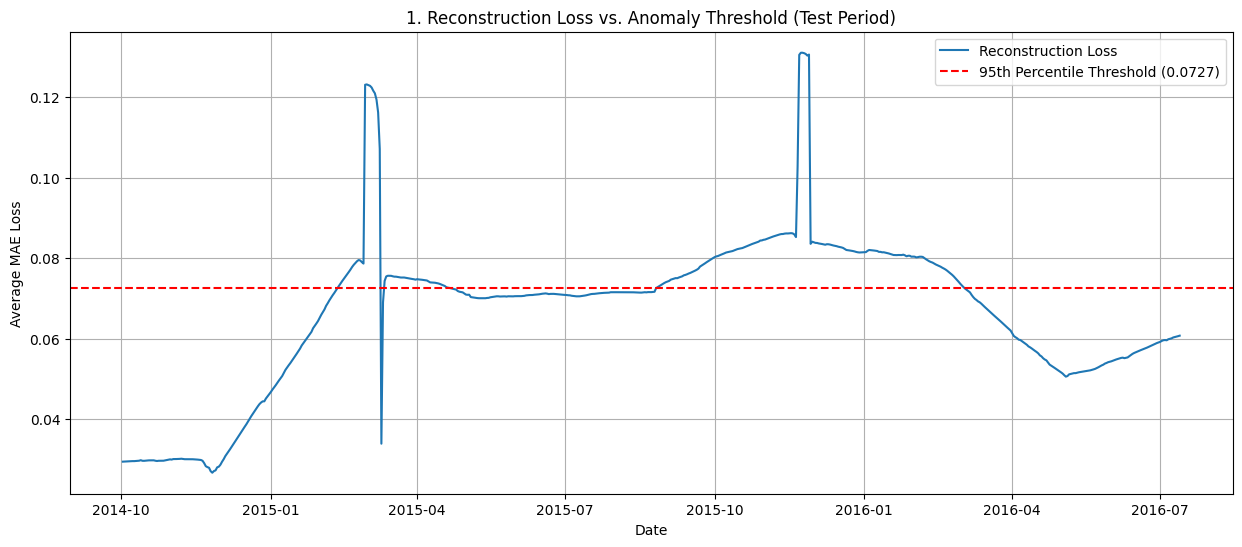

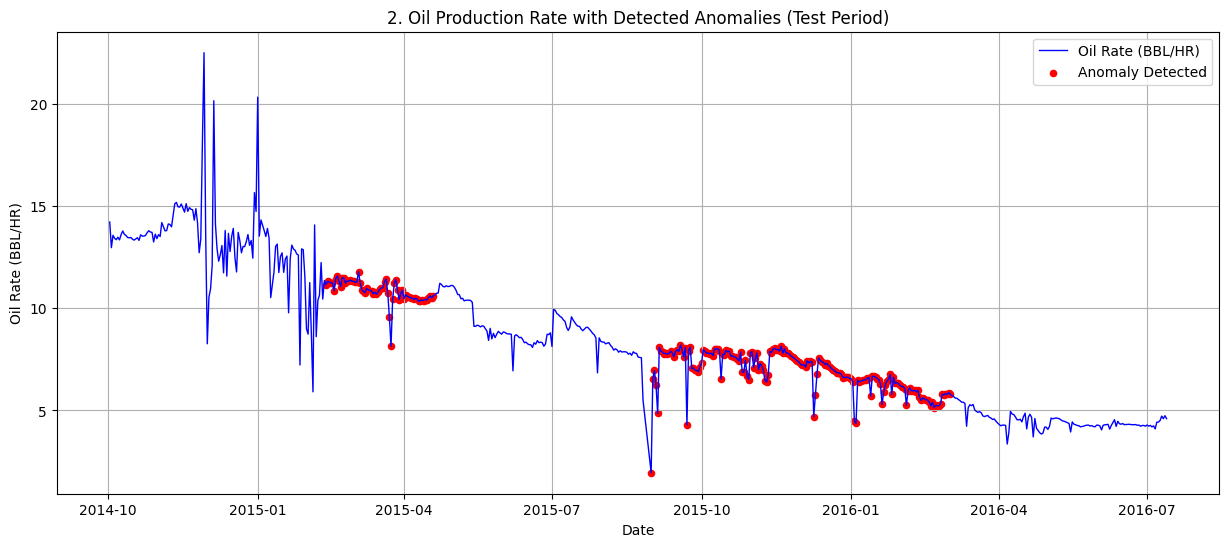

In [37]:
# --- Load and Re-Calculate Final Data (Ensuring consistency with the 99th Pct run) ---
# Assuming best_model, X_test_seq, X_train_seq, X_test_index_seq, and daily_df_final are defined

# Load the best model
best_model = load_model('best_model_90d.keras')

# Calculate Test Loss
X_test_pred = best_model.predict(X_test_seq, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test_seq), axis=1)
test_mae_loss = np.mean(test_mae_loss, axis=1)

# Calculate Training Loss and 99th Pct Threshold
X_train_pred = best_model.predict(X_train_seq, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train_seq), axis=1)
train_mae_loss = np.mean(train_mae_loss, axis=1)
ANOMALY_THRESHOLD = np.quantile(train_mae_loss, 0.95) # Using the confirmed 99th Pct

# Create loss DataFrame and flag anomalies
test_loss_df = pd.DataFrame(
    test_mae_loss,
    index=X_test_index_seq,
    columns=['Loss']
)
test_loss_df['Anomaly'] = test_loss_df['Loss'] > ANOMALY_THRESHOLD

# Prepare data for Plot 2
test_data_with_loss = daily_df_final.loc[X_test_index_seq]
test_data_with_loss['Anomaly'] = test_loss_df['Anomaly']
oil_rate_test = test_data_with_loss['OIL_RATE_BBL_HR']
anomalous_points = test_data_with_loss.loc[test_data_with_loss['Anomaly'] == True]

print(f"Plotting results using 95th Percentile Threshold: {ANOMALY_THRESHOLD:.6f}")


# --- Plot 1: Reconstruction Loss vs. Threshold ---
plt.figure(figsize=(15, 6))
plt.plot(test_loss_df.index, test_loss_df['Loss'], label='Reconstruction Loss')
plt.axhline(ANOMALY_THRESHOLD, color='r', linestyle='--', label=f'95th Percentile Threshold ({ANOMALY_THRESHOLD:.4f})')
plt.title('1. Reconstruction Loss vs. Anomaly Threshold (Test Period)')
plt.xlabel('Date')
plt.ylabel('Average MAE Loss')
plt.legend()
plt.grid(True)
plt.show()



# --- Plot 2: Oil Production Rate vs. Anomalies ---
plt.figure(figsize=(15, 6))
plt.plot(oil_rate_test.index, oil_rate_test.values, label='Oil Rate (BBL/HR)', color='blue', linewidth=1)
plt.scatter(anomalous_points.index, anomalous_points['OIL_RATE_BBL_HR'], color='red', marker='o', s=20, label='Anomaly Detected')
plt.title('2. Oil Production Rate with Detected Anomalies (Test Period)')
plt.xlabel('Date')
plt.ylabel('Oil Rate (BBL/HR)')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# best_model = load_model('best_model_101010.keras')
# best_model.save('final_lstm_autoencoder_model.keras')

# joblib.dump(scaler, 'fitted_minmax_scaler.pkl')